In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import pandas as pd
import math
#import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
from matplotlib import rc

def custom_grouping(index):
    return index // 1000

names_bw=['time', 'bw', 'op1', 'size', 'op2' ]
names_latency=['time', 'latency', 'op2', 'write_size', 'op3']

In [ ]:
# This is the 90/10 zipf random writes  pattern for DMHybrid (aka STL in the notebooks)
# The path should be /p5/worst_case/STL/1M/90-10-LBA/90Util/run1/lat_log_avg_lat.1.log

In [22]:
# Define a custom grouping function
  
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
#df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/90Util/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/90Util/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = 1048576
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)
last_non_zero_index = data_written_ms[data_written_ms.ne(0).any(axis=1)].index[-1]
data_written_ms = data_written_ms.loc[:last_non_zero_index]

/tmp/ipykernel_17998/3202147748.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.86634668
 8439.86634668 8439.86634668 8439.86634668 8439.86634668 8439.

46079


In [23]:
#assert math.ceil(data_written_ms.data_written_bytes.sum()) == len(df)*4096
print(math.ceil(data_written_ms.data_written_bytes.sum()))
print(len(df) * 1048576)

48318382081
48318382080


In [24]:
chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
df_grouped.reset_index(drop=True, inplace=True)
last_non_zero_index = df_grouped[df_grouped.ne(0).any(axis=1)].index[-1]
df_grouped = df_grouped.loc[:last_non_zero_index]
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped.describe())
print(df_grouped.info())

             index  data_written_bytes  cumulative_gb
count  5872.000000         5872.000000    5872.000000
mean   2935.500000            7.847411      40.043651
std    1695.244722           29.648598       5.758968
min       0.000000            0.000234       0.093369
25%    1467.750000            1.175768      38.421735
50%    2935.500000            1.556252      40.762818
75%    4403.250000            2.110963      43.294814
max    5871.000000          168.485531      45.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               5872 non-null   int64  
 1   data_written_bytes  5872 non-null   float64
 2   cumulative_gb       5872 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 137.8 KB
None


Average1: 2
Average2: 147


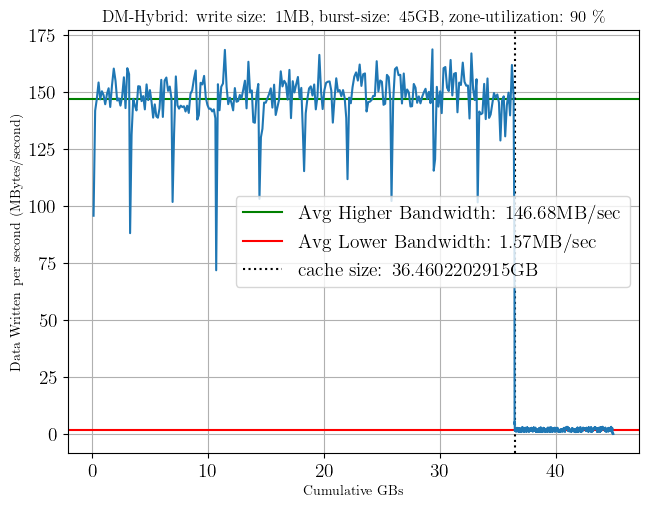

In [25]:
data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Filter the DataFrame for rows where 'data_written_bytes' is less than 75
filtered_df = df_grouped[df_grouped['data_written_bytes'] < 50]

# Get the corresponding 'cumulative_gb' values
cumulative_gb_values = filtered_df['cumulative_gb']

# If you want the first occurrence where 'data_written_bytes' is less than 75
first_cumulative_gb = cumulative_gb_values.iloc[0] if not cumulative_gb_values.empty else 45
# Plot vertical lines at x where y is higher than the threshold
plt.axvline(x=first_cumulative_gb, color='black', linestyle=':', label="cache size: " + str(round(first_cumulative_gb, 10)) + "GB")

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("DM-Hybrid: write size: 1MB, burst-size: 45GB, zone-utilization: 90 \%")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_90Util_STL_CGBW.png', bbox_inches='tight')
plt.show()

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0004351642173755653
The highest duration: 2579202.38159


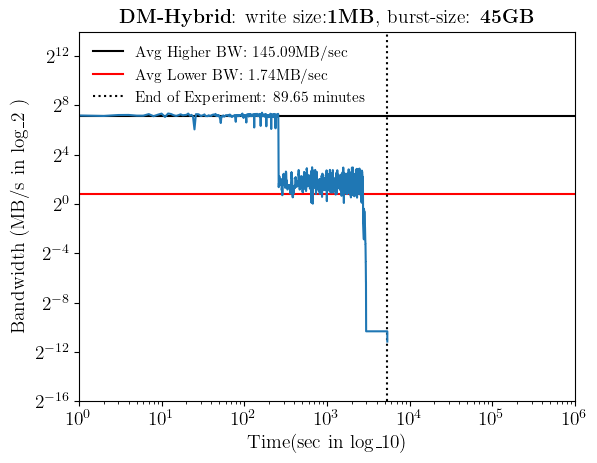

5379


In [86]:
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
max_duration = max(df['duration'])
print(f"The highest duration: {max_duration}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)
#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines
xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper left', fontsize=11, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{DM-Hybrid}$: write size:$\textbf{1MB}$, burst-size: $\textbf{45GB}$", fontsize=14)    
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_90Util_STL_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_90Util_9010_STL_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_90Util_9010_STL_BW.png', bbox_inches='tight', dpi=300)
plt.show()
print(str(df_grouped.index[-1]))

In [87]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/75Util/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

In [88]:
# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

/tmp/ipykernel_17998/2128149304.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.23631487
 4678.23631487 4678.23631487 4678.23631487 4678.23631487 4678.

46079


In [89]:
chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

Min Idx: 
2411


The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


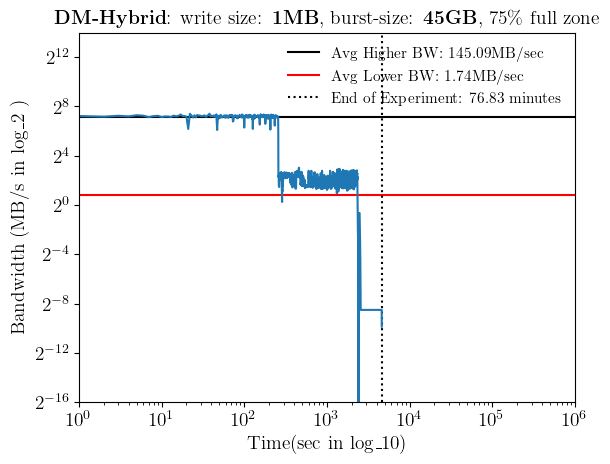

4610


In [90]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{DM-Hybrid}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$, 75\% full zone",fontsize=14)    
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_75Util_STL_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_75Util_STL_BW.jpg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_17998/3816367983.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


46079
Min Idx: 
5379
Average1: 2
Average2: 145


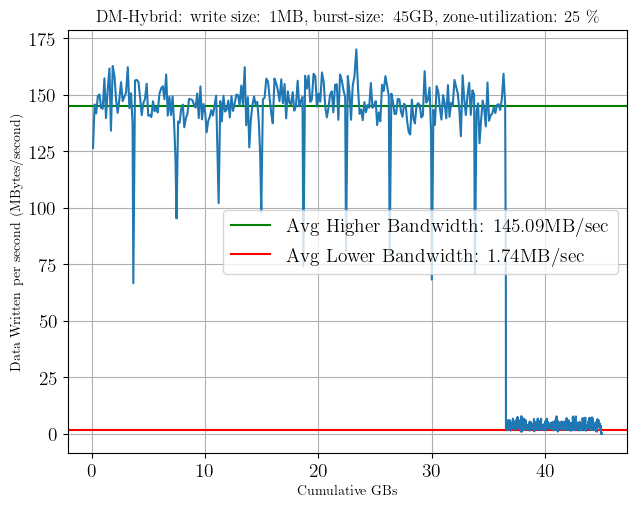

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0004351642173755653


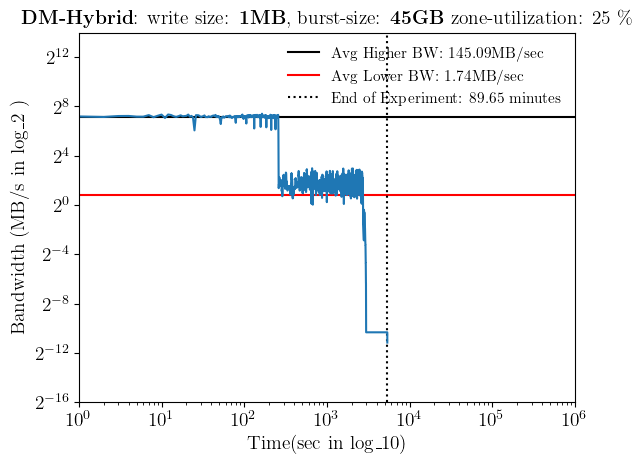

5379


In [91]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/25Util/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("DM-Hybrid: write size: 1MB, burst-size: 45GB, zone-utilization: 25 \%")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_25Util_HMHybrid_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{DM-Hybrid}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ zone-utilization: 25 \%",fontsize=14)    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_25Util_lsdm_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_25Util_DMHybrid_BW.pdf', bbox_inches='tight', format="pdf")
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_17998/3816367983.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438 24542.75664438 24542.75664438
 24542.75664438 24542.75664438]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


46079
Min Idx: 
5379
Average1: 2
Average2: 145


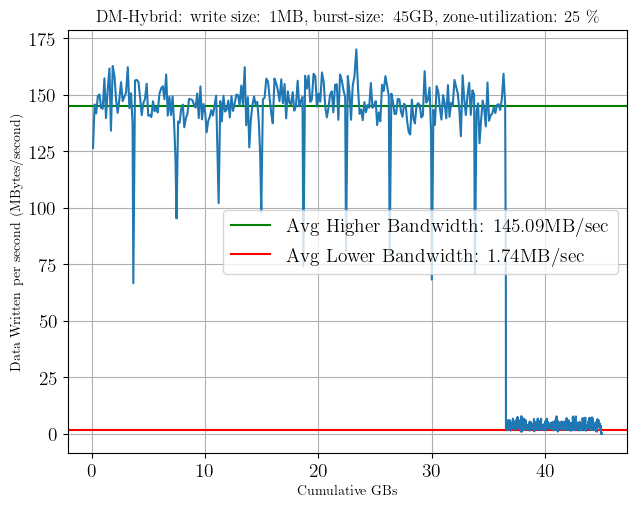

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0004351642173755653


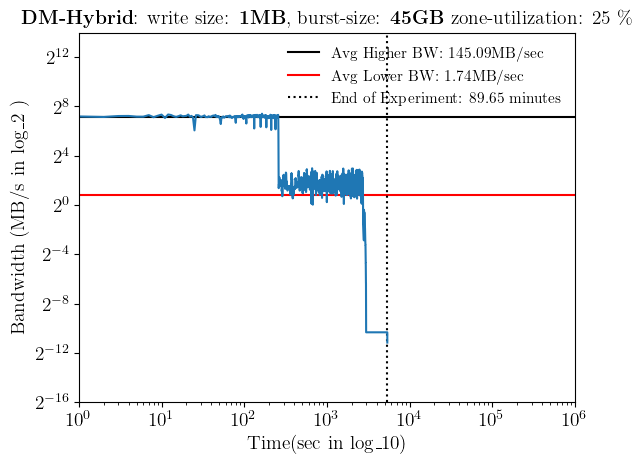

5379


In [92]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/25Util/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("DM-Hybrid: write size: 1MB, burst-size: 45GB, zone-utilization: 25 \%")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_25Util_HMHybrid_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{DM-Hybrid}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ zone-utilization: 25 \%",fontsize=14)    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_25Util_lsdm_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_25Util_DMHybrid_BW.pdf', bbox_inches='tight', format="pdf")
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_17998/571729851.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084.80667416
 11084.80667416 11084.80667416 11084.80667416 11084

46079
Min Idx: 
3389
Average1: 6
Average2: 118


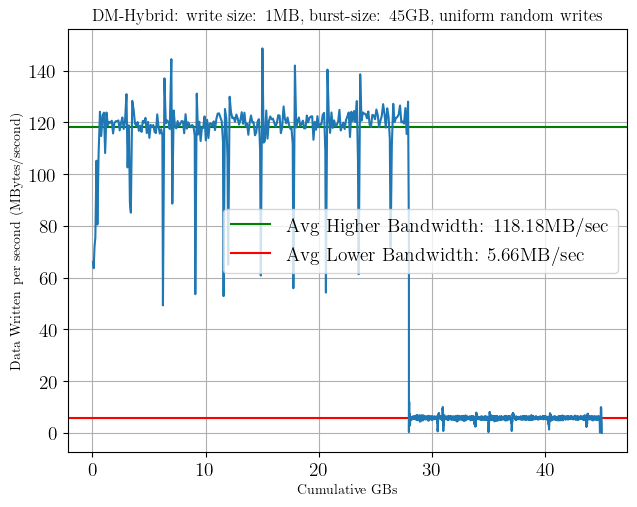

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.01921568645570783


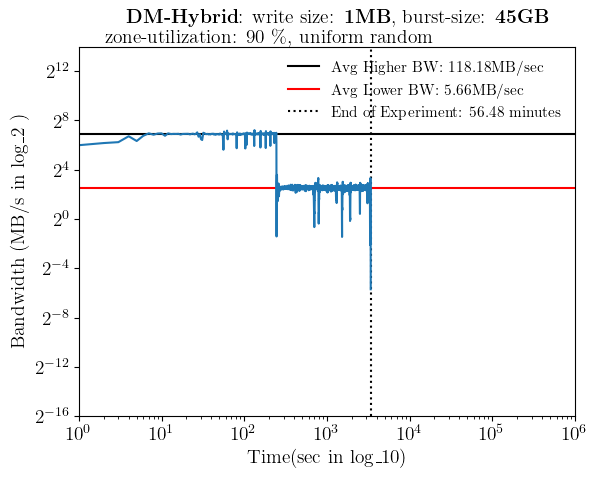

3389


In [93]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/uniform-random/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
#df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/90Util/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])



# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("DM-Hybrid: write size: 1MB, burst-size: 45GB, uniform random writes")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_25Util_HMHybrid_CGBW.png', bbox_inches='tight')
plt.show()


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{DM-Hybrid}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ \\ zone-utilization: 90 \%, uniform random",fontsize=14)    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/1M_90UtilUniform_lsdm_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_90UtilUniform_DMHybrid_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90UtilUniform_DMHybrid_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

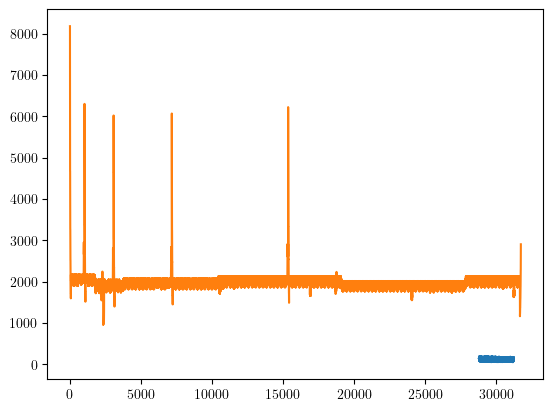

In [94]:
# TODO: Plot this - 10MB before and after the cache - for 4KB.

names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/cache-writes-impact/1MB/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
#df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/90-10-LBA/90Util/run1/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])
df['cumulative_gb'] = df['write_size'].cumsum() / (1024 ** 3)
df['bw'] = (1e3/df['duration']) * 1024 #KB/sec

threshold = 28.108398438
# Filter the DataFrame for rows where cumulative_gb is above the threshold
filtered_df = df[df['cumulative_gb'] > threshold]
plt.plot(filtered_df.index, filtered_df['bw'])

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/cache-writes-impact/6100-LBA/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])
df['cumulative_gb'] = df['write_size'].cumsum() / (1024 ** 2)
df['bw'] = (1e3/df['duration']) * 1024 #KB/sec
threshold = 0
# Filter the DataFrame for rows where cumulative_gb is above the threshold
filtered_df = df[df['cumulative_gb'] > threshold]
plt.plot(df.index, df['bw'])

#df = pd.read_csv(f'/home/surbhi/measurements/worst_case/STL/1M/cache-writes-impact/4KB/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

plt.show()
